RODDA Ocean Application SANI
Imperial College London - CMCC
Authors: César Quilodrán-Casas and Marco Stefanelli


Loading the data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pandas as pd
import netCDF4
import scipy
import numpy as np

In [2]:
directory_noDA = '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/'
directory_DA = '/data/c-quilo/CMCC/DA/SHYFEM_ASSIM_BIVARIATE/'
list_of_paths_noDA = sorted(glob.glob(directory_noDA + '/*'))
list_of_paths_DA = sorted(glob.glob(directory_DA + '/*'))
print(list_of_paths_noDA)

['/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0000.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0001.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0002.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0003.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0004.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0005.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0006.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0007.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0008.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0009.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0010.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0011.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0012.nos.nc', '/data/c-quilo/CMCC/NoDA/SHYFEM_NO_ASSIM/sst_saniv1_chunk_0013.

In [3]:
sst_noDA = np.zeros((365*24, 90351))
count = 0
for file in list_of_paths_noDA:
    data_noDA = xr.open_dataset(file)
    sst_noDA[24*count:24*(count+1), :] = data_noDA.temperature
    count += 1
    

In [4]:
sst_DA = np.zeros((365*24, 90351))
count = 0
for file in list_of_paths_DA:
    data_DA = xr.open_dataset(file)
    sst_DA[24*count:24*(count+1), :] = data_DA.temperature
    count += 1

In [5]:
print(sst_DA.shape)

(8760, 90351)


In [6]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [7]:
nFeatures = sst_noDA.shape[1]
encoder_inputs = keras.Input(shape=nFeatures)
alpha = 0.3

enc = keras.layers.Dense(512)(encoder_inputs)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)

# enc = keras.layers.Dense(256)(enc)
# enc = keras.layers.LeakyReLU(alpha)(enc)
# enc = keras.layers.Dropout(0.5)(enc)
# enc = keras.layers.BatchNormalization()(enc)

# enc = keras.layers.Dense(128)(enc)
# enc = keras.layers.LeakyReLU(alpha)(enc)
# enc = keras.layers.Dropout(0.5)(enc)
# enc = keras.layers.BatchNormalization()(enc)

# enc = keras.layers.Dense(256)(enc)
# enc = keras.layers.LeakyReLU(alpha)(enc)
# enc = keras.layers.Dropout(0.5)(enc)
# enc = keras.layers.BatchNormalization()(enc)

enc = keras.layers.Dense(512)(enc)
enc = keras.layers.LeakyReLU(alpha)(enc)
enc = keras.layers.Dropout(0.5)(enc)
enc = keras.layers.BatchNormalization()(enc)

output = keras.layers.Dense(nFeatures, activation='sigmoid')(enc)
#enc = keras.layers.LeakyReLU(alpha)(enc)
#enc = keras.layers.Dropout(0.5)(enc)
#enc = keras.layers.BatchNormalization()(enc)

encoder = keras.Model(encoder_inputs, output, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90351)]           0         
_________________________________________________________________
dense (Dense)                (None, 512)               46260224  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0   

2022-10-14 12:29:58.980574: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-14 12:29:58.980666: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 12:29:58.981562: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
n_samples = sst_noDA.shape[0]
indices = np.arange(n_samples)
#Scaling
from sklearn.preprocessing import MinMaxScaler

scalernoDA = MinMaxScaler()
scalerDA = MinMaxScaler()

sst_noDA_scaled = scalernoDA.fit_transform(sst_noDA, (0,1))
sst_DA_scaled = scalerDA.fit_transform(sst_DA, (0,1))

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(sst_noDA_scaled, sst_DA_scaled, indices, test_size = 0.2, random_state = 42, shuffle=True)



In [9]:
encoder.compile(loss='mse', optimizer=tf.optimizers.Nadam())

In [10]:
encoder.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=500, batch_size=32)

2022-10-14 12:30:08.908540: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-14 12:30:08.928081: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3504000000 Hz


Epoch 1/500
 64/219 [=======>......................] - ETA: 1:34 - loss: 0.0280

KeyboardInterrupt: 

In [19]:
from xarray.coding.times import decode_cf_datetime

# Read lon lat
lon_lat = xr.open_dataset('lon_lat_sani.nc')
lon = lon_lat.longitude.values
lat = lon_lat.latitude.values
index = indices_test[100]
print(index/24)
print((index%24))

index_date = str(decode_cf_datetime(index, 'hours since 2017-01-01 0:00'))[:-10]
print(index_date)
predDA = encoder.predict(np.expand_dims(sst_noDA_scaled[index], 0))

sst_noDA_unscaled = scalernoDA.inverse_transform(sst_noDA_scaled)
sst_DA_unscaled = scalerDA.inverse_transform(sst_DA_scaled)
predDA = np.squeeze(scalerDA.inverse_transform(predDA))
print(indices_test.shape)

36.083333333333336
2
2017-02-06T02:00:00
(1752,)


2017-09-10T08:00:00
2017-08-20T12:00:00
2017-09-07T14:00:00
2017-11-16T18:00:00
2017-05-19T07:00:00
2017-08-29T01:00:00
2017-09-06T20:00:00
2017-12-31T22:00:00
2017-09-11T07:00:00
2017-10-27T01:00:00


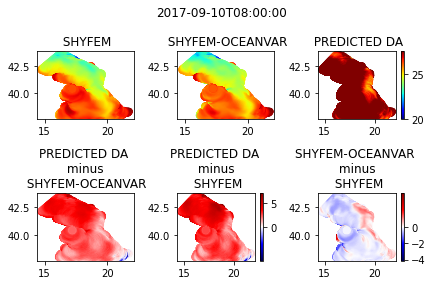

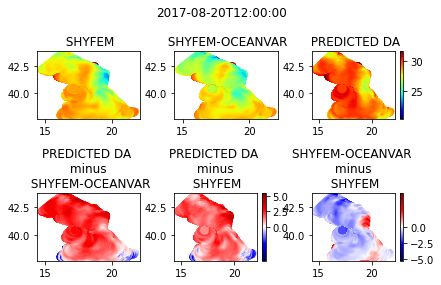

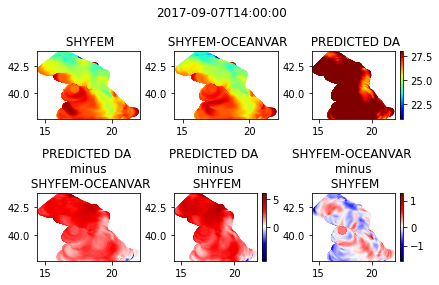

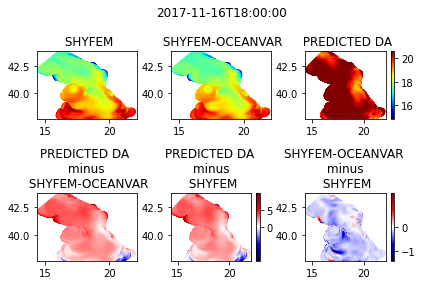

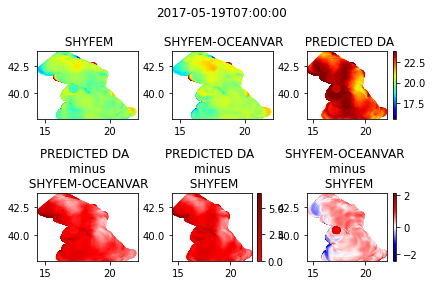

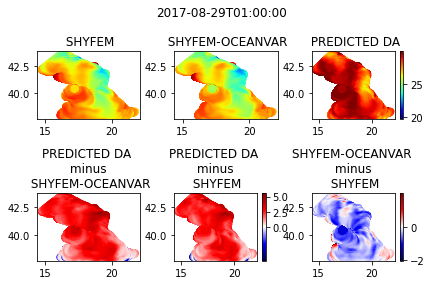

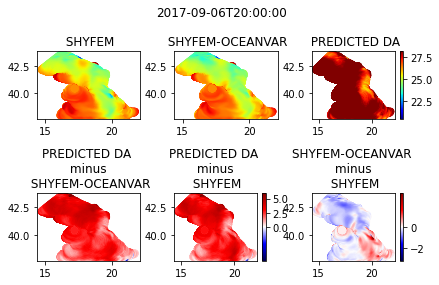

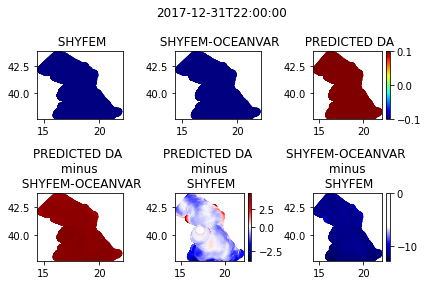

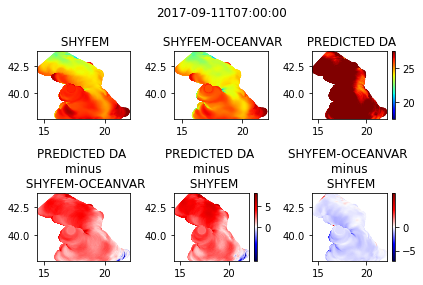

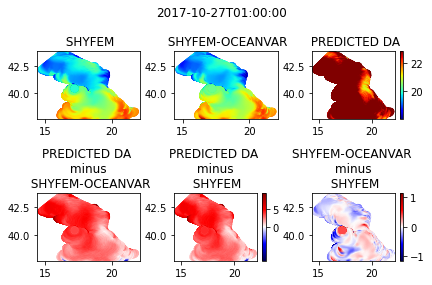

In [21]:
for i in range(10):
    index = indices_test[i]
    index_date = str(decode_cf_datetime(index, 'hours since 2017-01-01 0:00'))[:-10]
    predDA = encoder.predict(np.expand_dims(sst_noDA_scaled[index], 0))
    predDA = np.squeeze(scalerDA.inverse_transform(predDA))

    import mercator
    from matplotlib.colors import TwoSlopeNorm

    fig, axs = plt.subplots(nrows=2, ncols=3)#,sharex='col', sharey='row',subplot_kw={'projection': 'mercator'})
    axs[0,0].set_title(" SHYFEM")
    #axs[0,0].coastline('medsea_h.shp', sea=None, zorder=2)
    axs[0,0].scatter(lon,lat,c=sst_noDA[index, :], 
                    vmin=np.min(sst_DA[index, :]), 
                    vmax=np.max(sst_DA[index, :]), 
                    cmap='jet')

    axs[0,1].set_title(" SHYFEM-OCEANVAR")
    #axs[0,1].coastline('medsea_h.shp', sea=None, zorder=2)
    axs[0,1].scatter(lon,lat,c=sst_DA[index, :], 
                    vmin=np.min(sst_DA[index, :]), 
                    vmax=np.max(sst_DA[index, :]), 
                    cmap='jet')

    axs[0,2].set_title(" PREDICTED DA")
    #axs[0,2].coastline('medsea_h.shp', sea=None, zorder=2)
    cb1=axs[0,2].scatter(lon,lat,c=predDA[:], 
                        vmin=np.min(sst_DA[index, :]), 
                        vmax=np.max(sst_DA[index, :]), 
                        cmap='jet')

    cbar1 = fig.colorbar(cb1, ax=axs[0][2])

    ###########################################################################################################################

    axs[1,0].set_title("PREDICTED DA \n minus \n SHYFEM-OCEANVAR")
    #axs[1,0].coastline('medsea_h.shp', sea=None, zorder=2)
    axs[1,0].scatter(lon,lat,c=predDA[:]-sst_DA[index, :],
                    cmap='seismic', norm=TwoSlopeNorm(vcenter=0))#.,
                                                    #vmin=np.min(predDA[:]-sst_DA[index, :]), 
                                                    #vmax=np.max(predDA[:]-sst_DA[index, :])))

    axs[1,1].set_title("PREDICTED DA \n minus \n SHYFEM")
    #axs[1,1].coastline('medsea_h.shp', sea=None, zorder=2)
    cb2=axs[1,1].scatter(lon,lat,c=predDA[:]-sst_noDA[index, :],
                    cmap='seismic', norm=TwoSlopeNorm(vcenter=0))#.,
                                                    #vmin=np.min(predDA[:]-sst_DA[index, :]), 
                                                    #vmax=np.max(predDA[:]-sst_DA[index, :])))

    cbar2 = fig.colorbar(cb2, ax=axs[1][1])

    axs[1,2].set_title("SHYFEM-OCEANVAR \n minus \n SHYFEM")
    #axs[1,2].coastline('medsea_h.shp', sea=None, zorder=2)
    cb3=axs[1,2].scatter(lon,lat,c=sst_DA[index, :]-sst_noDA[index, :], 
                        cmap='seismic', norm=TwoSlopeNorm(vcenter=0))#.,
                                                        #vmin=np.min(sst_DA[index, :]-sst_noDA[index, :]), 
                                                        #vmax=np.max(sst_DA[index, :]-sst_noDA[index, :])))

    cbar3 = fig.colorbar(cb3, ax=axs[1][2])


    fig.suptitle(index_date)
    print(str(index_date))
    fig.tight_layout()
    plt.savefig('Test_' + str(index_date))
